# Random Forest Classifier for Object Exploration

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns # we will see in the next lesson
import matplotlib.pyplot as plt
import csv
import glob
import os
import cv2
import matplotlib.patches as patches
import math
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
import random

In [2]:
def multipoint_to_point_dist(xArray, yArray, pointCoord):
    from scipy.spatial import distance
    from numpy import stack
    xyCoord = np.stack((xArray, yArray), axis=1)
    dist = distance.cdist(xyCoord, pointCoord)

    return dist

In [3]:
#Opening all the .mp4(DLC-Analized) files in the specified directory (mp4 because DLC usuallyy creates mp4 files)
path = r'C:\Users\Francesca\Desktop\Lab\Esperimenti\DLC\Videos\DLC-AnalyzedVideos'
extension1 = 'mp4'
extension2 = 'csv'
os.chdir(path)
videos = glob.glob('*.{}'.format(extension1)) #list of all the videos
trackingFiles = glob.glob('*-filtered.{}'.format(extension2)) #list of the tracking files
EFIFiles = glob.glob('*-EFI.{}'.format(extension2)) #Collecting EFI(Exploration Frames Info) files

## Creation of a Training Dataset based on DLC-Analysed
The training dataset is created using frame-by-frame manually labelled videos with:
- 0 = no object exploration
- 1 = object exploration

Analyzing video...030621-T2-ST1-Resnet50-iter15-snap8000
Arena selection done
Body coordinates remapped inside the arena
Body coordinates remapped to [0,1]
EFI File found
Analyzing video...030621-T2-ST2-Resnet50-iter15-snap8000
Arena selection done
Body coordinates remapped inside the arena
Body coordinates remapped to [0,1]
EFI File found
Analyzing video...050721-T1-TT-Resnet50-iter15-snap8000
Arena selection done
Body coordinates remapped inside the arena
Body coordinates remapped to [0,1]
EFI File found
Analyzing video...050721-T2-TT-Resnet50-iter15-snap8000
Arena selection done
Body coordinates remapped inside the arena
Body coordinates remapped to [0,1]
EFI File found
Analyzing video...050721-T3-TT-Resnet50-iter15-snap8000
Arena selection done
Body coordinates remapped inside the arena
Body coordinates remapped to [0,1]
EFI File found
Analyzing video...180821-T1-TT-Resnet50-iter15-snap8000
Arena selection done
Body coordinates remapped inside the arena
Body coordinates remapped to

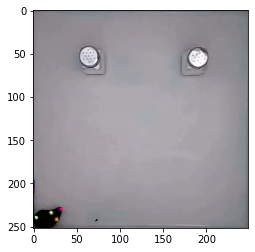

In [4]:
for i in range (len(videos)): #For every video in the directory

#############################
#     
    #OPEN THE CSV WITH TRACKING POSITIONS
    df = pd.read_csv(os.path.join(path, trackingFiles[i]), 
    header=[1,2], #setting the first 2 rows as column names
    dtype =np.float64, #defining the type of the objects inside the dataframe
    index_col=0
    ) #Take the first column as index by default


    #OPEN THE VIDEO FILE
    cap = cv2.VideoCapture(
    os.path.join(path, videos[i])
    ) 

    #SUBDIVIDE THE FILE NAME IN ORDER TO REMOVE THE .MP4 EXTENSION
    fileName = videos[i].split('.',2)
    
    print('Analyzing video...'+ fileName[0])

###############################
    #ARENA SELECTION BY USER
    try:
        
        numOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) #Tot frames
        chosenFrame = round(numOfFrames-300)# Choose the (lastFrame - 300) frame
        cap.set(cv2.CAP_PROP_POS_FRAMES,chosenFrame) #set the current frame as the random chosen frame
        _, chosenFrame = cap.read() # Read the frame
        roi=cv2.selectROI('Select the arena, then press space and enter', chosenFrame) #save the coordinates of the top left corner and the bottom right corner
        roi_cropped=chosenFrame[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]
        plt.imshow(roi_cropped)
        cv2.waitKey(0) # Wait until there is key input or automatically eliminate the window after 1000ms, 
        #0 means only use the key input to end the window
        cv2.destroyAllWindows()
        arenaSelection = input('Do you want to change your selection?[y/n]')
    
        while arenaSelection == 'y':
            roi=cv2.selectROI(chosenFrame) #save the coordinates of the top left corner and the bottom right corner
            roi_cropped=chosenFrame[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]
            plt.imshow(roi_cropped)
            cv2.waitKey(0) # Wait until there is key input or automatically eliminate the window after 1000ms, 
            #0 means only use the key input to end the window
            cv2.destroyAllWindows()
            arenaSelection = input('Do you want to change your selection?[y/n]')

        print('Arena selection done' )        

        #Selection of the object on the right
        obj1Roi = cv2.selectROI('Select the object on the right, then press space and enter', chosenFrame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        ballSelection = input('Do you want to change your selection? [y/n]')
            
        while ballSelection == 'y':
            obj1Roi = cv2.selectROI('Select the object on the right, then press space and enter', chosenFrame)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            ballSelection = input('Do you want to change your selection? [y/n]')

        #Selection of the object on the left    
        obj2Roi = cv2.selectROI('Select the object on the left, then press space and enter', chosenFrame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        saltSelection = input('Do you want to change your selection? [y/n]')
            
        while saltSelection == 'y':
            obj2Roi = cv2.selectROI('Select the object on the left, then press space and enter', chosenFrame)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            saltSelection = input('Do you want to change your selection? [y/n]')    
             
    except:
        print('An error occurred while getting a frame for the video.')

    finally:
        cap.release()  #I have to close the file

    

    #Making the selected arena a square arena
    arenaSide = (roi[2] + roi[3])/2 
    xThresholdLeft = roi[0]
    xThresholdRight = roi[0] + arenaSide
    yThresholdUp = roi[1]
    yThresholdDown = roi[1] + arenaSide

###########################################

    #REMAPPING BODY PARTS COORDINATES FOLLOWING OUTSIDE THE ARENA
    bodyParts = df.keys()
    dfRemapped = df.copy()
    for ib in range(bodyParts.size): #For every tracked body part
        for ifr in range(dfRemapped.shape[0]): #For every frame
            if bodyParts[ib][1] == 'x':
                if dfRemapped[bodyParts[ib]][ifr] < xThresholdLeft:
                    dfRemapped[bodyParts[ib]][ifr] = xThresholdLeft
                if dfRemapped[bodyParts[ib]][ifr] > xThresholdRight:
                    dfRemapped[bodyParts[ib]][ifr] = xThresholdRight
                else:
                    if bodyParts[ib][1] == 'y':
                        if dfRemapped[bodyParts[ib]][ifr] < yThresholdUp:
                            dfRemapped[bodyParts[ib]][ifr] = yThresholdUp
                        if dfRemapped[bodyParts[ib]][ifr] > yThresholdDown:
                            dfRemapped[bodyParts[ib]][ifr] = yThresholdDown

    print('Body coordinates remapped inside the arena')

##############################################

    #SCALING BODY PART COORDINATES AND OBJECTS TO [0,1]

    ##Body parts coordinates
    dfScaled = dfRemapped.copy()
    for ib in range(bodyParts.size): #For every tracked body part
        if bodyParts[ib][1] == 'x':
            dfScaled[bodyParts[ib]] = (dfScaled[bodyParts[ib]] - roi[0])/arenaSide
        else:
            if bodyParts[ib][1] == 'y':
                dfScaled[bodyParts[ib]] = (dfScaled[bodyParts[ib]] - roi[1])/arenaSide

    ##Objects coordinates
    
    scaledObj1 = np.array([obj1Roi[0]-roi[0], obj1Roi[1]-roi[1], obj1Roi[2], obj1Roi[3]])
    scaledObj1 = scaledObj1/arenaSide
    scaledObj2 = np.array([obj2Roi[0]-roi[0], obj2Roi[1]-roi[1], obj2Roi[2], obj2Roi[3]])
    scaledObj2 = scaledObj2/arenaSide
    print('Body coordinates remapped to [0,1]')
    
#############################################
          
    #Csv containing information about the frames in which the mouse explores or not explores the objects (1 is the object on the right, 2 on the left)
    EFIName = fileName[0]+'-EFI.csv'
    if EFIName in EFIFiles:
        print('EFI File found')
        expFrameIndic = pd.read_csv(os.path.join(path,EFIName), 
        header=[0,1], #setting the first 2 rows as column names
        dtype ={('No_Exp','Start'):np.int64, ('No_Exp','Stop'):np.int64, ('Exp','Start'):np.int64, ('Exp','Stop'):np.int64,
        ('Object','Num'):np.int64, ('Video','Name'):str}, #defining the type of the objects inside the dataframe
        index_col=None) #Take the first column as index by default

        #Extracting body parts' positions from the originale dataframe and converting to np arrays
        xNose = dfScaled[bodyParts[0]].to_numpy()
        yNose = dfScaled[bodyParts[1]].to_numpy()   
        xOrDx = dfScaled[bodyParts[3]].to_numpy()
        yOrDx = dfScaled[bodyParts[4]].to_numpy()
        xOrSx = dfScaled[bodyParts[6]].to_numpy()
        yOrSx = dfScaled[bodyParts[7]].to_numpy()
        xCulo = dfScaled[bodyParts[9]].to_numpy()
        yCulo = dfScaled[bodyParts[10]].to_numpy()
        xCodaC = dfScaled[bodyParts[12]].to_numpy()
        yCodaC = dfScaled[bodyParts[13]].to_numpy()
        xCodaP = dfScaled[bodyParts[15]].to_numpy()
        yCodaP = dfScaled[bodyParts[16]].to_numpy()

        pointCoord1 = np.ndarray(shape = (1,2))
        pointCoord2 = np.ndarray(shape = (1,2))
        pointCoord1[0,0] = scaledObj1[0]+scaledObj1[2]/2 #Obj1 is the obj on the right
        pointCoord1[0,1] = scaledObj1[1]+scaledObj1[3]/2
        pointCoord2[0,0] = scaledObj2[0]+scaledObj2[2]/2 #Obj2 is the object on the left
        pointCoord2[0,1] = scaledObj2[1]+scaledObj2[3]/2

        obj1Radius = (scaledObj1[2] + scaledObj1[3])/4
        obj2Radius = (scaledObj2[2] + scaledObj2[3])/4


        #Dataframe containing all the distances from the objects(1 right, 2 left) and without the mouse tail
        distDf = {
        'noseD1': multipoint_to_point_dist(xNose, yNose, pointCoord1).flatten() - obj1Radius,
        'noseD2': multipoint_to_point_dist(xNose, yNose, pointCoord2).flatten() - obj2Radius,
        'orDxD1': multipoint_to_point_dist(xOrDx, yOrDx, pointCoord1).flatten() - obj1Radius,
        'orDxD2': multipoint_to_point_dist(xOrDx, yOrDx, pointCoord2).flatten() - obj2Radius,
        'orSxD1': multipoint_to_point_dist(xOrSx, yOrSx, pointCoord1).flatten() - obj1Radius,
        'orSxD2': multipoint_to_point_dist(xOrSx, yOrSx, pointCoord2).flatten() - obj2Radius,
        'culoD1': multipoint_to_point_dist(xCulo, yCulo, pointCoord1).flatten() - obj1Radius,
        'culoD2': multipoint_to_point_dist(xCulo, yCulo, pointCoord2).flatten() - obj2Radius,
        }
        distDf = pd.DataFrame.from_dict(distDf)

        df_x = distDf.iloc[int(expFrameIndic[('No_Exp','Start')][0]):][:]
        #df_y = np.zeros(df_x.shape[0]) #E' un dataframe tutto di 0
        arr = np.zeros(df_x.shape[0])
        dataDfy = {'labels':arr}
        df_y = pd.DataFrame(data=dataDfy)    
        for ik in range(expFrameIndic.shape[0]):
            for ic in range(int(expFrameIndic[('Exp', 'Start')][ik]), int(expFrameIndic[('Exp', 'Stop')][ik])+1):
                df_y.iloc[ic-int(expFrameIndic[('No_Exp','Start')][0])][0] = 1 #Converto in 1 i frame in cui c'è esplorazione

        suffixDist = fileName[0]+'-dist.csv'
        suffixTarget = fileName[0]+'-target.csv'
        csvDistName = os.path.join(path, suffixDist)
        df_x.to_csv(csvDistName,  index = False)
        #np.savetxt(suffixTarget, df_y, delimiter=",")
        df_y.to_csv(suffixTarget, index = False)
    else:
            print('No EFI file found')

## Random Forest Classifier

In [6]:
#Concatenate all the distance dataframes obtained from different videos
from sklearn.metrics import plot_confusion_matrix, classification_report
distFiles = glob.glob('*-dist.{}'.format(extension2)) #Collecting distance files
df1 = pd.read_csv(os.path.join(path, distFiles[0]), index_col=False) #Take the first column as index by default

for id in range(len(distFiles)-1):
    df2 = pd.read_csv(os.path.join(path, distFiles[id+1]),  index_col=False)
    frames = [df1, df2]
    df1 = pd.concat(frames)

df_x = df1

#Concatenate the target(those containing the 0 1 labels for exploration or not) dataframes
targetFiles = glob.glob('*-target.{}'.format(extension2)) #Collecting EFI(Exploration Frames Info) files
dft1 = pd.read_csv(os.path.join(path, targetFiles[0]), index_col=False) #Take the first column as index by default

for it in range(len(targetFiles)-1):
    dft2 = pd.read_csv(os.path.join(path, targetFiles[it+1]),  index_col=False)
    frames = [dft1, dft2]
    dft1 = pd.concat(frames)

df_y = dft1

#Training and testing datasets (stratified)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.3, stratify = df_y, random_state = 1)

#Scaling
from sklearn.preprocessing import StandardScaler #for Scaling the features

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw) # computes std and mean of each feature and scaling. 
X_test  = scaler.transform(X_test_raw)  # scales the test data.

from sklearn.ensemble import RandomForestClassifier
# 1. instantiate model Random Forest with 50 decision trees
model = RandomForestClassifier(n_estimators=100,random_state=42, class_weight= 'balanced') 
# 2. fit model to data
model.fit(X_train, y_train)   
# 3. predict on new data
y_pred = model.predict(X_test)   
print('='*20,'Testing RANDOM FOREST Results','='*20)
print(classification_report(y_test, y_pred))
print('='*60)

<ipython-input-6-e2a807de39bf>:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


==================== Testing RANDOM FOREST Results ====================
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     35649
         1.0       0.96      0.92      0.94      2148

    accuracy                           0.99     37797
   macro avg       0.98      0.96      0.97     37797
weighted avg       0.99      0.99      0.99     37797



## Confusion Matrix

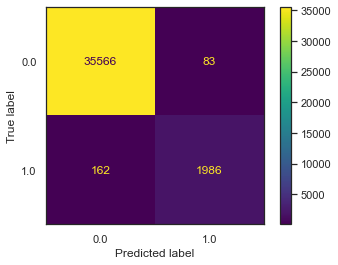

==================== Training Set Results ====================
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     83182
         1.0       1.00      1.00      1.00      5011

    accuracy                           1.00     88193
   macro avg       1.00      1.00      1.00     88193
weighted avg       1.00      1.00      1.00     88193

==================== Testing Set Results ====================
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     35649
         1.0       0.96      0.92      0.94      2148

    accuracy                           0.99     37797
   macro avg       0.98      0.96      0.97     37797
weighted avg       0.99      0.99      0.99     37797



In [7]:
from sklearn.metrics import plot_confusion_matrix, classification_report

sns.set(style="white")
plot_confusion_matrix(model, X_test, y_test) 
plt.show()

# Building a text report showing the main classification metrics.
print('='*20,'Training Set Results','='*20)
print(classification_report(y_train, model.predict(X_train)))

print('='*20,'Testing Set Results','='*20)
report_testing = classification_report(y_test, y_pred)
print(report_testing)
print('='*60)